In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
import io
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import tree
import graphviz
import seaborn as sns

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 2016.csv to 2016.csv
User uploaded file "2016.csv" with length 13591 bytes


In [ ]:
datapath = io.StringIO(uploaded['2016.csv'].decode('utf-8'))
df = pd.read_csv(datapath)
df = df.rename(columns={"Happiness Score": "Happiness", "Economy (GDP per Capita)": "Economy", "Health (Life Expectancy)": "Health", "Trust (Government Corruption)": "Trust"})
happy = df[['Country', 'Happiness']]
happy

,Country,Happiness
0,Denmark,7.526
1,Switzerland,7.509
2,Iceland,7.501
3,Norway,7.498
4,Finland,7.413
...,...,...
152,Benin,3.484
153,Afghanistan,3.360
154,Togo,3.303
155,Syria,3.069


In [ ]:
uploaded2 = files.upload()
for fn in uploaded2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded2[fn])))

Saving total_health_spending_per_person_us.csv to total_health_spending_per_person_us.csv
User uploaded file "total_health_spending_per_person_us.csv" with length 15464 bytes


In [ ]:
# HEALTH SPENDING PER PERSON
datapath2 = io.StringIO(uploaded2['total_health_spending_per_person_us.csv'].decode('utf-8'))
healthSpending = pd.read_csv(datapath2)
healthSpending = healthSpending.add_prefix('hs_')
countries = healthSpending['hs_country']
healthSpending = healthSpending.iloc[0:190, 16:17] #SELECTING MOST RECENT YEAR
healthSpending['Country'] = countries
print(healthSpending)
healthSpending.shape

     hs_2009               Country
0       37.7           Afghanistan
1      123.0                Angola
2      241.0               Albania
3     3100.0               Andorra
4     1450.0  United Arab Emirates
..       ...                   ...
185    204.0                 Samoa
186     63.2                 Yemen
187    649.0          South Africa
188     72.9                Zambia
189      NaN              Zimbabwe

[190 rows x 2 columns]


(190, 2)

In [ ]:
uploaded4 = files.upload()
for fn in uploaded4.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded4[fn])))

Saving income_per_person_gdppercapita_ppp_inflation_adjusted.csv to income_per_person_gdppercapita_ppp_inflation_adjusted.csv
User uploaded file "income_per_person_gdppercapita_ppp_inflation_adjusted.csv" with length 243817 bytes


In [ ]:
# INCOME PER PERSON
datapath4 = io.StringIO(uploaded4['income_per_person_gdppercapita_ppp_inflation_adjusted.csv'].decode('utf-8'))
income = pd.read_csv(datapath4)
income = income.add_prefix('income_')
countries = income['income_country']
income = income.iloc[0:195, 218:219] # SELECTING 2016 
income['Country'] = countries 
income['income_2016'] = income['income_2016'].replace({"k":"*1e3"}, regex=True).map(pd.eval).astype(int)
print(income.head())
income.shape

   income_2016               Country
0         2060           Afghanistan
1         7310                Angola
2        12800               Albania
3        56300               Andorra
4        67200  United Arab Emirates


(195, 2)

In [ ]:
uploaded3 = files.upload()
for fn in uploaded3.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded3[fn])))

Saving population_density_per_square_km.csv to population_density_per_square_km.csv
User uploaded file "population_density_per_square_km.csv" with length 164015 bytes


In [ ]:
# POPULATION DENSITY 
datapath5 = io.StringIO(uploaded3['population_density_per_square_km.csv'].decode('utf-8'))
popDensity = pd.read_csv(datapath5)
popDensity = popDensity.add_prefix('pd_')
countries = popDensity['pd_country']
popDensity = popDensity.iloc[0:236, 68:69] # SELECTING 2016
popDensity['Country'] = countries
popDensity['pd_2016'] = popDensity['pd_2016'].replace({"k":"*1e3"}, regex=True).map(pd.eval).astype(int)
print(popDensity.head())
popDensity.shape

   pd_2016      Country
0      586        Aruba
1       54  Afghanistan
2       24       Angola
3      171     Anguilla
4      105      Albania


(236, 2)

In [ ]:
# MERGING DATASETS
happy = happy.merge(popDensity, how='inner', on='Country')
happy = happy.merge(income, how='inner', on='Country')
happy = happy.merge(healthSpending, how='inner', on='Country')
print(happy.shape)
happy = happy.dropna()
print(happy.shape)
print(happy)

(140, 5)
(135, 5)
         Country  Happiness  pd_2016  income_2016  hs_2009
0        Denmark      7.526      135        55400   6420.0
1    Switzerland      7.509      211        69100   7810.0
2        Iceland      7.501        3        55600   3720.0
3         Norway      7.498       17        64099   8090.0
4        Finland      7.413       18        47600   3980.0
..           ...        ...      ...          ...      ...
135        Benin      3.484      103         3050     31.0
136  Afghanistan      3.360       54         2060     37.7
137         Togo      3.303      144         2010     40.6
138        Syria      3.069      103         3770     96.6
139      Burundi      2.905      430          774     20.7

[135 rows x 5 columns]


<ipython-input-14-3cebd42287fd>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = happy.corr().round(2)


<Axes: >

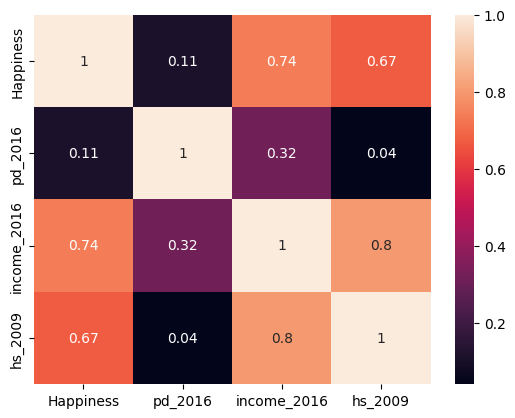

In [ ]:
correlation_matrix = happy.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

# Multiple Linear Regression 

In [ ]:
X = pd.DataFrame(np.c_[happy['hs_2009'], happy['pd_2016'], happy['income_2016']], 
                 columns = ['hs_2009','pd_2016', 'income_2016'])
Y = happy['Happiness']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_train)

(94, 3)
(41, 3)
(94,)
(41,)
     hs_2009  pd_2016  income_2016
83    2370.0    112.0      33000.0
2     3720.0      3.0      55600.0
14    4670.0    237.0      53100.0
47    4070.0    336.0      41500.0
51     917.0    126.0      30100.0
..       ...      ...          ...
102    123.0    102.0      11000.0
90     317.0     51.0      14500.0
75     546.0     97.0      16600.0
34     178.0     17.0      11700.0
65     853.0     30.0      33800.0

[94 rows x 3 columns]


In [ ]:
happinessMLR = lm.LinearRegression()  
happinessMLR.fit(X_train, Y_train)   

b = happinessMLR.intercept_
print("intercept b = ", b)

m = happinessMLR.coef_  
print("slope, m = ", m)

rSquare = happinessMLR.score(X_train, Y_train)    
print("r Squared value on training data =", rSquare) 

rSquare = happinessMLR.score(X_test, Y_test)    
print("r Squared value on testing data =", rSquare) 

intercept b =  4.406858696022904
slope, m =  [ 4.11551995e-05 -2.14801807e-04  4.20786156e-05]
r Squared value on training data = 0.5761938795224022
r Squared value on testing data = 0.45810824132960226


In [ ]:
print("model values")
y_pred = happinessMLR.predict(X_test)
print(y_pred[:5])

print("actual values")
print(Y_test[:5])


model values
[5.52466707 4.98157113 4.49911023 5.85137723 6.63699247]
actual values
50     5.919
39     6.218
128    3.739
46     5.977
34     6.361
Name: Happiness, dtype: float64


# Random Forest Model

In [ ]:
X = happy[['hs_2009','pd_2016', 'income_2016']]  # inputs
y = happy.Happiness   # output

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(101, 3)
(34, 3)


In [ ]:
dt = tree.DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

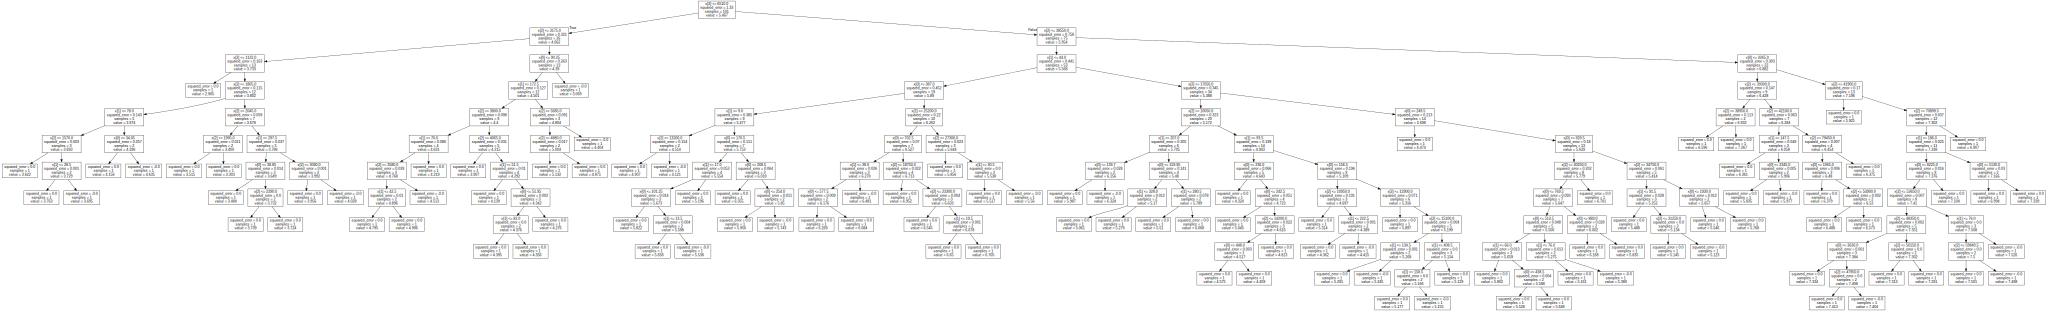

In [ ]:
gdata = tree.export_graphviz(dt, out_file=None)
graph = graphviz.Source(gdata)
graph

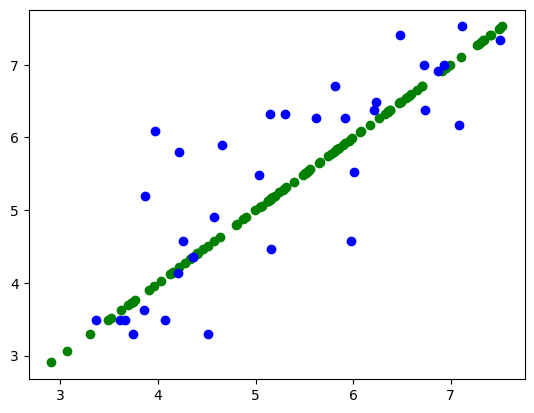

In [ ]:
plt.scatter(y_train, dt.predict(X_train), c="green")
plt.scatter(y_test, dt.predict(X_test), c="blue")
plt.show()

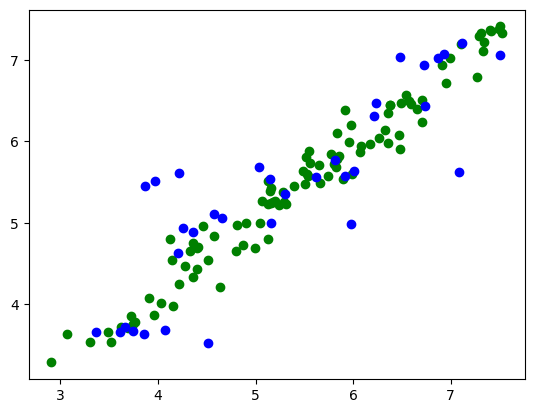

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

plt.scatter(y_train, rfr.predict(X_train), c="green")
plt.scatter(y_test, rfr.predict(X_test), c="blue")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

train_predict = rfr.predict(X_train)
test_predict = rfr.predict(X_test)

r2 = r2_score(y_train, train_predict)
print("r2 training set", r2)

r2 = r2_score(y_test, test_predict)
print("r2 testing set", r2)

r2 training set 0.9592262762105244
r2 testing set 0.7190703633009776


The model was very accurate on the training data with a r2 value of 0.96 that value dropped to 0.52 when it came to the testing data. 